<a href="https://colab.research.google.com/github/AnnieL1229/COGS108_Repo/blob/main/DSC140B_HW3_Q6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader

In [2]:
# Set random seed for reproducibility
torch.manual_seed(42)

# Hyperparameters

In [3]:
# DO NOT CHANGE
batch_size = 128
learning_rate = 1e-3
num_epochs = 10
input_size = 28 * 28  # FashionMNIST images are 28x28 pixels
hidden_sizes = [512, 256, 128]  # Three hidden layers
num_classes = 10  # 10 classes in FashionMNIST

# Data

In [4]:
# Define transforms for the training and test sets
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [5]:
# TODO: Load the FashionMNIST dataset
# Complete this with appropriate batch_size
trainset = torchvision.datasets.FashionMNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

# Test set
testset = torchvision.datasets.FashionMNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

100%|██████████| 26.4M/26.4M [00:02<00:00, 11.9MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 203kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.76MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 13.0MB/s]


In [6]:
# Class labels
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

In [7]:
# Function to show an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

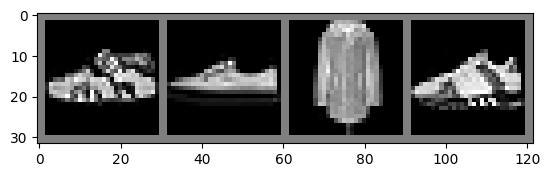

Sandal, Sneaker, Coat , Sneaker


In [8]:
# Get random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images[:4]))

# Print labels
print(', '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

# MLP

In [9]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, num_classes):
        super(MLP, self).__init__()
        # The architecture should have:
        # - An input layer that connects to the first hidden layer (512 neurons)
        # - ReLU activation after the first hidden layer
        # - A second hidden layer (256 neurons)
        # - ReLU activation after the second hidden layer
        # - A third hidden layer (128 neurons)
        # - ReLU activation after the third hidden layer
        # - An output layer with 10 neurons (one for each class)
        # Hint: Use nn.Sequential, nn.Linear, nn.ReLU for a clean implementation

         # Create a list to hold all layers
        layers = []

        # Input layer: from input_size to first hidden layer
        layers.append(nn.Linear(input_size, hidden_sizes[0]))
        layers.append(nn.ReLU())

        # Hidden layers
        for i in range(len(hidden_sizes) - 1):
            layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i + 1]))
            layers.append(nn.ReLU())

        # Output layer
        layers.append(nn.Linear(hidden_sizes[-1], num_classes))

        # Create the sequential model
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        # Flatten the input image (batch_size, 1, 28, 28) -> (batch_size, 784)
        x = x.view(x.size(0), -1)
        # Forward pass through the network
        return self.layers(x)

# CNN

In [10]:
class CNN(nn.Module):
    """
    A simple Convolutional Neural Network (CNN) for classifying FashionMNIST images.

    Architecture:
    - Two convolutional layers with ReLU activation and max pooling.
    - A fully connected classification head.
    """
    def __init__(self, num_classes):
        super(CNN, self).__init__()

        # Convolution Layer 1: output size remains 28x28
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)  # output: 64 x 14 x 14

        # Convolution Layer 2: output size remains 14x14 → downsample to 7x7
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)  # output: 64 x 7 x 7

        # Flatten layer (no parameters)
        self.flatten = nn.Flatten()

        # Fully connected classifier
        self.fc = nn.Linear(64 * 7 * 7, num_classes)  # 64 channels × 7 height × 7 width = 3136

    def forward(self, x):
        """
        Forward pass of the CNN.

        Args:
            x (torch.Tensor): Input batch of shape (batch_size, 1, 28, 28)

        Returns:
            torch.Tensor: Logits of shape (batch_size, num_classes)
        """
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)

        x = self.flatten(x)
        x = self.fc(x)

        return x


# Train

In [11]:
# TODO: Initialize the model
model_mlp = MLP(input_size, hidden_sizes, num_classes)
model_cnn = CNN(num_classes)

In [12]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Move models to device
model_mlp.to(device)
model_cnn.to(device)

Using device: cuda


CNN(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=3136, out_features=10, bias=True)
)

In [13]:
# TODO: Implement the training loop
def train(model, trainloader, num_epochs):

    # TODO: Define loss function and optimizer (Adam)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Set model to training mode
    model.train()

    # Lists to track progress
    train_losses = []
    train_accs = []

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for i, data in enumerate(trainloader, 0):
            # TODO: Get the inputs and move them to the device
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # TODO: Zero the parameter gradients
            optimizer.zero_grad()

            # TODO: Forward pass and compute loss
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # TODO: Backward pass and optimizer step
            loss.backward()
            optimizer.step()

            # Track statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Print statistics every 100 mini-batches
            if i % 100 == 99:
                batch_loss = running_loss / 100
                batch_acc = 100 * correct / total
                print(f'Epoch: {epoch + 1}, Batch: {i + 1}, Loss: {batch_loss:.3f}, Accuracy: {batch_acc:.2f}%')
                running_loss = 0.0
                correct = 0
                total = 0

        # TODO: Calculate epoch-level statistics
        epoch_loss = running_loss / len(trainloader)
        epoch_acc = 100 * correct / total
        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc)

        print(f'Epoch {epoch + 1} completed. Train Loss: {epoch_loss:.3f}, Train Accuracy: {epoch_acc:.2f}%')

    print('Finished Training')
    return train_losses, train_accs

In [14]:
# Implement the evaluation function
def evaluate(model, dataloader):

    # TODO: Define loss function
    criterion = nn.CrossEntropyLoss()

    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for data in dataloader:
            # TODO: Get the inputs and move them to the device
            images, labels = data
            images, labels = images.to(device), labels.to(device)

            # TODO: Forward pass and compute loss
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Track statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = running_loss / len(dataloader)
    accuracy = 100 * correct / total

    return avg_loss, accuracy

In [15]:
print("Training MLP...")
train_losses_mlp, train_accs_mlp = train(model_mlp, trainloader, num_epochs)

print("Training CNN...")
train_losses_cnn, train_accs_cnn = train(model_cnn, trainloader, num_epochs)

Training MLP...
Epoch: 1, Batch: 100, Loss: 0.767, Accuracy: 71.90%
Epoch: 1, Batch: 200, Loss: 0.508, Accuracy: 81.14%
Epoch: 1, Batch: 300, Loss: 0.455, Accuracy: 83.67%
Epoch: 1, Batch: 400, Loss: 0.429, Accuracy: 84.34%
Epoch 1 completed. Train Loss: 0.060, Train Accuracy: 85.43%
Epoch: 2, Batch: 100, Loss: 0.386, Accuracy: 85.98%
Epoch: 2, Batch: 200, Loss: 0.373, Accuracy: 86.25%
Epoch: 2, Batch: 300, Loss: 0.381, Accuracy: 85.98%
Epoch: 2, Batch: 400, Loss: 0.366, Accuracy: 86.55%
Epoch 2 completed. Train Loss: 0.052, Train Accuracy: 86.84%
Epoch: 3, Batch: 100, Loss: 0.336, Accuracy: 87.74%
Epoch: 3, Batch: 200, Loss: 0.333, Accuracy: 87.70%
Epoch: 3, Batch: 300, Loss: 0.334, Accuracy: 87.59%
Epoch: 3, Batch: 400, Loss: 0.347, Accuracy: 87.20%
Epoch 3 completed. Train Loss: 0.048, Train Accuracy: 87.76%
Epoch: 4, Batch: 100, Loss: 0.308, Accuracy: 88.55%
Epoch: 4, Batch: 200, Loss: 0.311, Accuracy: 88.47%
Epoch: 4, Batch: 300, Loss: 0.318, Accuracy: 88.34%
Epoch: 4, Batch: 400,

# Evaluate

In [16]:
# Test the model
print("Evaluating MLP...")
test_loss_mlp, test_acc_mlp = evaluate(model_mlp, testloader)
print(f'MLP: Test Loss: {test_loss_mlp:.3f}, Test Accuracy: {test_acc_mlp:.2f}%')

print("Evaluating CNN...")
test_loss_cnn, test_acc_cnn = evaluate(model_cnn, testloader)
print(f'CNN: Test Loss: {test_loss_cnn:.3f}, Test Accuracy: {test_acc_cnn:.2f}%')

Evaluating MLP...
MLP: Test Loss: 0.329, Test Accuracy: 88.69%
Evaluating CNN...
CNN: Test Loss: 0.240, Test Accuracy: 91.85%


# Plot

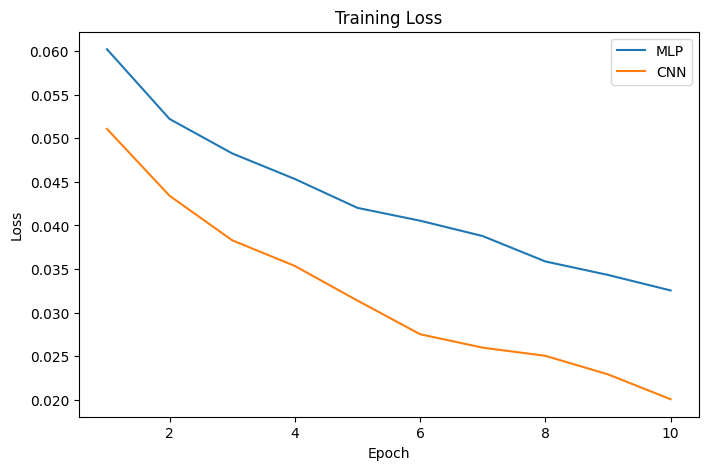

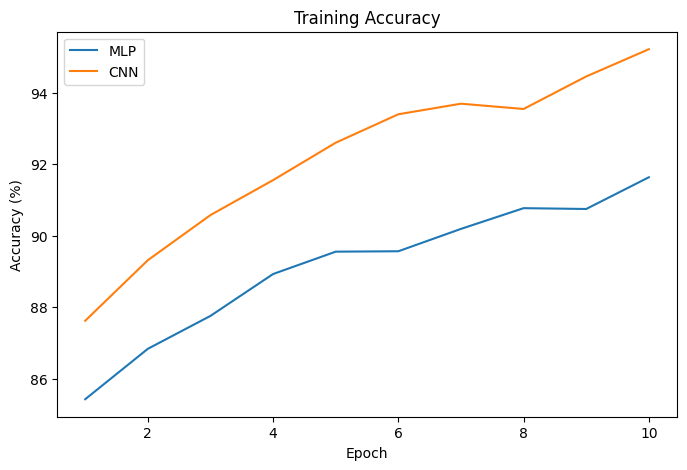

In [17]:
# Plot training progress
plt.figure(figsize=(8, 5))
plt.legend(['MLP', 'CNN'])
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(
    range(1, num_epochs + 1),
    train_losses_mlp,
    label='MLP'
)
plt.plot(
    range(1, num_epochs + 1),
    train_losses_cnn,
    label='CNN'
)
plt.legend()
plt.show()


plt.figure(figsize=(8, 5))
plt.legend(['MLP', 'CNN'])
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')

plt.plot(
    range(1, num_epochs + 1),
    train_accs_mlp,
    label='MLP'
)
plt.plot(
    range(1, num_epochs + 1),
    train_accs_cnn,
    label='CNN'
)
plt.legend()
plt.show()



# Visualize Predictions

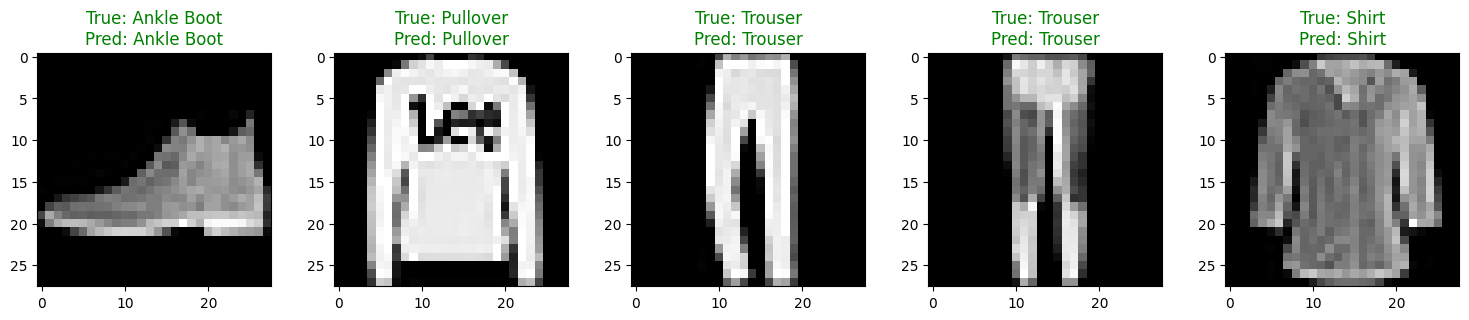

In [18]:
# Visualize some predictions
def visualize_predictions(model, testloader, classes, num_images=5):
    model.eval()

    # Get a batch of test images
    dataiter = iter(testloader)
    images, labels = next(dataiter)
    images, labels = images[:num_images].to(device), labels[:num_images].to(device)

    # Make predictions
    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

    # Move images back to CPU for visualization
    images = images.cpu()

    # Plot the images with their true and predicted labels
    fig = plt.figure(figsize=(15, 3))
    for i in range(num_images):
        ax = fig.add_subplot(1, num_images, i + 1)
        ax.imshow(images[i].squeeze(), cmap='gray')
        color = 'green' if predicted[i] == labels[i] else 'red'
        ax.set_title(f'True: {classes[labels[i]]}\nPred: {classes[predicted[i]]}', color=color)

    plt.tight_layout()
    plt.show()

# Visualize some predictions
visualize_predictions(model_mlp, testloader, classes)